# Solar Wind Propagation Delay Prediction

In this project, we are trying to predict the propagation delay of a solar wind using an ensemble of regression algorithms (random forest, knn, extra trees and gradient boosting algorithms) and neural network (RNN).

Packages uses:
1. Numpy 
2. Pandas
3. Matplotlib
4. Scipy
5. Scikit-learn
6. Pytorch

The regression problem was solved using the following steps: 

    1. First csv file had 79 by 11 dimensions while all other sets had 80 by 11 dimensions. So, at first, we interpolated one additional row in each matrix in the first csv using linear interpolation so as to make the dimension equal in all the sets.    
    2. Multiple excel files were merged. 
    3. Data concatenated from multiple excel files were randomly shuffled to reduce the bias in the model.  
    4. Data was normalized by subtracting each data by mean and then dividing by standard deviation. 
    5. Dimension of data was reduced using PCA. 
    6. Data understanding and visualization.
    7. Data was splitted into 3 chunks.
    8. Apply algorithms on the dataset. 
    9. Appropriate hyperparameter selection. 
    10. Evaluation of result on test dataset. 

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time

import sklearn
from sklearn.model_selection import train_test_split

# Preprocessing algorithms
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# For calculating loss and r2 score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Algorithms used in an ensemble regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor

# Pytorch packages
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Preparation and Preprocessing data
from src.data_preparation.interpolate_data import *
from src.data_preparation.preprocess_data import get_feature_target_array
from src.data_preparation.prepare_data import *

# Data visualization
from src.data_visualization.plot_graphs import *

# Data in the matrix form for using in deep learning models
from src.data_loader_for_dl.SolarWindDataset import SolarWindDataset

# Deep learning models
from src.model_train.train_rnn import RNN

%matplotlib inline

In [2]:
# Ignore filter warnings
import warnings
warnings.filterwarnings('ignore')

We have divided the model training into two parts:

    Part 1. Using machine learning algorithms (ensemble of random forest, knn, extra trees and gradient boosting algorithms) to predict the propagation delay.
    Part 2. Using neural network (RNN) to predict the propagation delay.
    
For Part 1, the data sets were created using 2 methods and the ensemble regressor was applied on each of those 2 sets. Data sets were created by:

    Method 1. 80 by 11 matrix was converted to 1 by 880 vector as scikit-learn algorithms can only work on vector. 
    Method 2. 1 by 11 vector was created by taking the average of each 11 columns of 80 by 11 matrix. 

Data produced using both of the methods in Part 1 almost gave the same result.

For Part 2, the data was taken in the matrix form itself.

## Plotting each attributes

For understanding about the data, firstly, we plotted histogram plot of each of the attribute and target values.

In [3]:
df = get_all_concatenated_dataframes()
df = df.apply(pd.to_numeric)

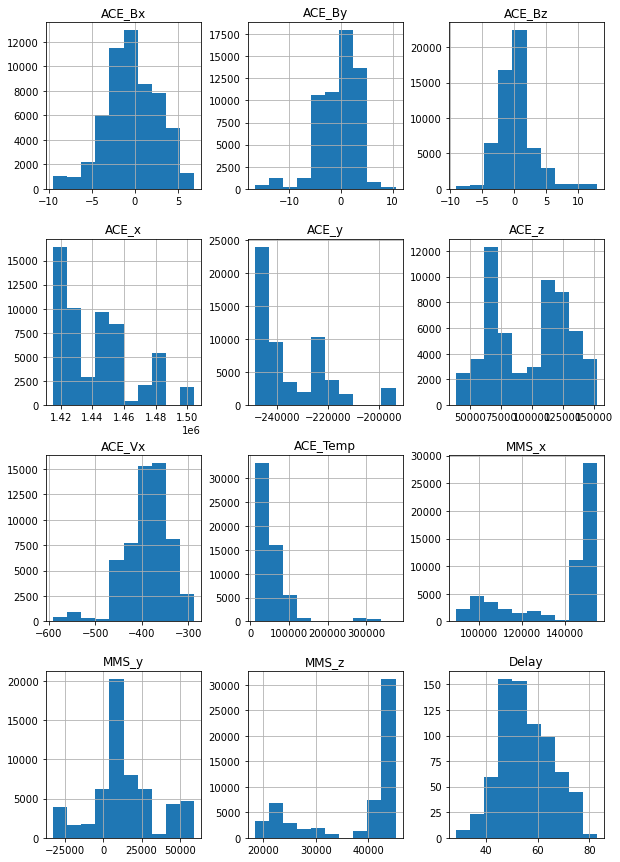

In [4]:
visualize_all_attributes(df)

From the histogram plot, we can see that the distribution is quite different in each of the attributes and none of them are normalized so, on each part (Part 1 and Part 2), we have normalized the data before applying any algorithms. One each part, we have looked at the distribution of the entire data set as well instead of only the attributes in order to figure out the total distribution range of each of the values in the dataset and making correct normalizing decisions.

### Part 1. Using machine learning algorithms (ensemble of random forest, knn, extra trees and gradient boosting algorithm) to predict the propagation delay.

### Method 1. Conversion of 80 by 11 matrix into 1 by 880 vector

In [377]:
# get 1 by 880 vector 
dataX1, dataY1 = reshape_each_data_1_by_880()
# shuffle the data
X1, y1 = sklearn.utils.shuffle(dataX1, dataY1)

(array([  8.,  23.,  59., 156., 153., 111.,  99.,  64.,  45.,   4.]),
 array([28.25 , 33.725, 39.2  , 44.675, 50.15 , 55.625, 61.1  , 66.575,
        72.05 , 77.525, 83.   ]),
 <BarContainer object of 10 artists>)

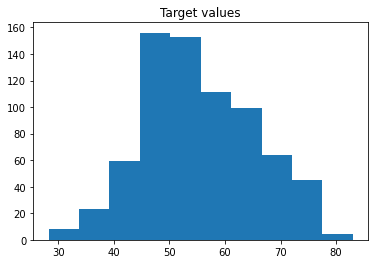

In [378]:
# Distribution of target value
plt.title("Target values")
plt.hist(y1)

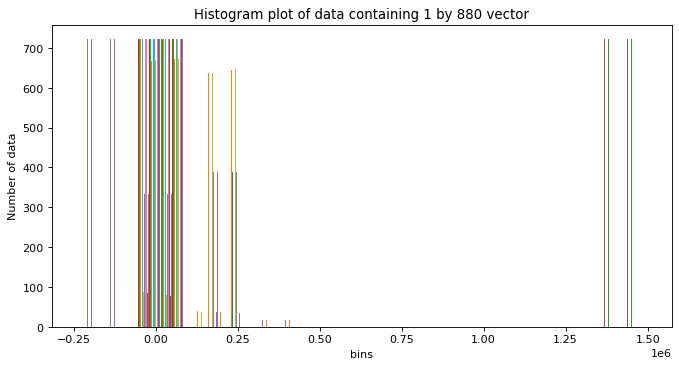

In [379]:
# Distribution of data (each data containing 1 by 880 vector) 
plot_hist(X1.squeeze(), "Histogram plot of data containing 1 by 880 vector")

We can see that our data has many values nearer to 0. Also, there are many huge values like 1.35 * 1e6. For normalizing the data, we subtracted each data by mean of the whole dataset and divided by the standard deviation.

### 1.1.1 Normalization of data

In [380]:
# Standarization of data
scaler = StandardScaler()
scaler.fit(X1.squeeze())
X_standardized1 = scaler.transform(X1.squeeze())

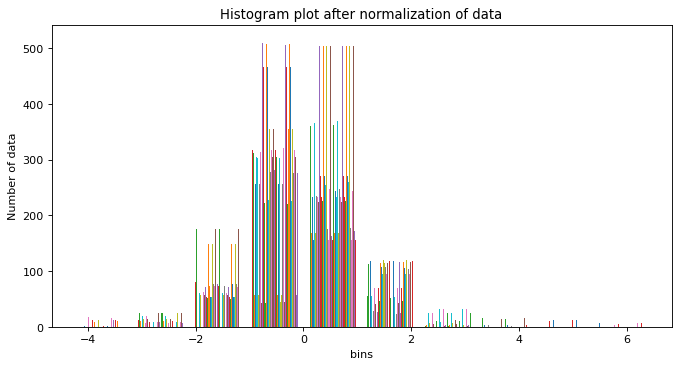

In [381]:
plot_hist(X_standardized1, "Histogram plot after normalization of data")

### 1.1.2 Dimensionality reduction

In [382]:
# Apply pca to data to preserve 0.95 important features
pca = PCA(n_components=0.95)
pca.fit(X_standardized1)
pca_X1 = pca.transform(X_standardized1)

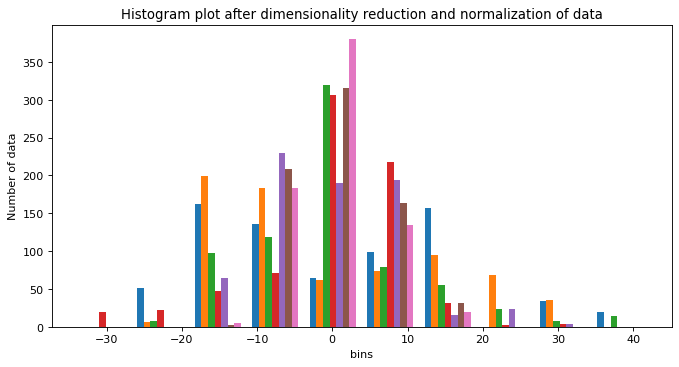

In [383]:
plot_hist(pca_X1, "Histogram plot after dimensionality reduction and normalization of data")

In [384]:
pca_X1

array([[ 16.46391371,  -3.39760512,  -2.28650142, ...,  -3.35788617,
         -3.93226034,  -5.38195054],
       [ 16.92308855,  -3.95046043,  -1.4132634 , ...,  -6.43366197,
          1.60824956,   3.95330824],
       [-14.66663069, -19.10541414,  12.74316178, ..., -12.57392215,
          1.00262209,  -1.90651338],
       ...,
       [ 18.03178434,  -5.46780827,   0.98174037, ...,  -1.64990623,
         -1.16213586,  -1.10962924],
       [ 12.00204223,  19.69141253, -17.59749146, ...,  -8.2655963 ,
         -8.81217139,  -5.97151049],
       [ -9.99191063, -15.49273454,  -1.47447601, ...,   1.65895039,
          4.87062687,   4.35530952]])

As we still have large values greater than 30 in our dataset so, re-normalizing the values so as to get only the values between 0 and 1 for reducing the bias in the model.

In [385]:
scaler2 = MinMaxScaler()
scaler2.fit(pca_X1)
X_norm1 = scaler2.transform(pca_X1)

In [386]:
X_norm1

array([[0.62662087, 0.30499697, 0.3147001 , ..., 0.26966931, 0.27931932,
        0.27923802],
       [0.63331127, 0.29442422, 0.32817454, ..., 0.19750932, 0.47256154,
        0.58220386],
       [0.17303379, 0.00460242, 0.54661426, ..., 0.05345426, 0.45143843,
        0.39202961],
       ...,
       [0.64946551, 0.26540661, 0.36513047, ..., 0.30973978, 0.37593588,
        0.41789164],
       [0.56160925, 0.74654899, 0.07844495, ..., 0.15453079, 0.10911749,
        0.26010448],
       [0.24114672, 0.07369094, 0.32723   , ..., 0.38736801, 0.58634693,
        0.59525038]])

Next, we split the data into train, test and validation set in the 70:20:10 ratio

In [387]:
# Split into train, validation and test set in the ratio 70:20:10
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_norm1, y1, test_size=0.1, shuffle=True, random_state=1)
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=0.2, shuffle=True, random_state=1)

In [388]:
print(X_train1.shape)
print(X_val1.shape)
print(X_test1.shape)

(519, 7)
(130, 7)
(73, 7)


### 1.1.3 Using Voting Regressor For Training

After getting normalized data, we trained an ensemble regressor containing k-nearest neighbor, random forest regressor, gradient boosting and extra trees regressor. The appropriate n_estimator and max_depth in random forest regressor, max_depth in extra trees regressor and n_estimators in gradient boosting regressor was found using loss verses the particular hyperparameter plot.

### 1.1.3.1 Choosing an appropriate n_estimators for Random Forest Regressor: 

In [389]:
rf_loss_train1 = []
rf_loss_val1 = []
rf_loss_test1 = []
rf_i_values1 = []

print("Random Forest Regressor - n_estimators")
i = 0
n_estimators_list = [3, 5, 10, 50, 100, 500, 5000]
while i < len(n_estimators_list):
    start_time = time.time()
    # Initialize random forest regressor
    clf = RandomForestRegressor(n_estimators=n_estimators_list[i], random_state = 1)
    tree = clf.fit(X_train1, y_train1)
    building_time = time.time() - start_time
    train_results = tree.predict(X_train1)
    loss_train = mean_squared_error(train_results, y_train1)
    val_results = tree.predict(X_val1)
    loss_val = mean_squared_error(val_results, y_val1)
    test_results = tree.predict(X_test1)
    loss_test = mean_squared_error(test_results, y_test1)
    print("n_estimator = {}: ".format(n_estimators_list[i]), end = "")
    print("Train Loss = {0:.2f}, ".format(loss_train), end = "")
    print("Validation Loss = {0:.2f}, ".format(loss_val), end = "")
    print("Test Loss = {0:.2f}, ".format(loss_test), end = "")
    print("buildTime = {0:.2f}s".format(building_time), end = "\n")
    rf_loss_train1.append(loss_train)
    rf_loss_val1.append(loss_val)
    rf_loss_test1.append(loss_test)
    rf_i_values1.append(n_estimators_list[i])
    i += 1

Random Forest Regressor - n_estimators
n_estimator = 3: Train Loss = 3.64, Validation Loss = 14.93, Test Loss = 6.83, buildTime = 0.01s
n_estimator = 5: Train Loss = 2.46, Validation Loss = 14.88, Test Loss = 6.78, buildTime = 0.02s
n_estimator = 10: Train Loss = 2.15, Validation Loss = 12.57, Test Loss = 6.10, buildTime = 0.03s
n_estimator = 50: Train Loss = 1.71, Validation Loss = 9.90, Test Loss = 5.02, buildTime = 0.13s
n_estimator = 100: Train Loss = 1.59, Validation Loss = 10.30, Test Loss = 5.20, buildTime = 0.29s
n_estimator = 500: Train Loss = 1.61, Validation Loss = 10.36, Test Loss = 5.87, buildTime = 1.19s
n_estimator = 5000: Train Loss = 1.58, Validation Loss = 10.19, Test Loss = 5.56, buildTime = 11.59s


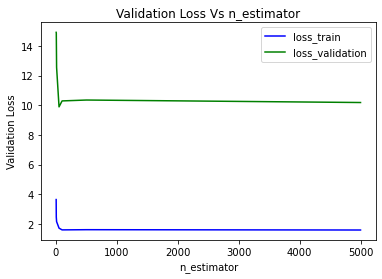

In [390]:
# Plotting validation loss vs n_estimator graph
plot_loss_graph(rf_i_values1, rf_loss_train1, rf_loss_val1, "Validation Loss Vs n_estimator", "n_estimator", "Validation Loss")

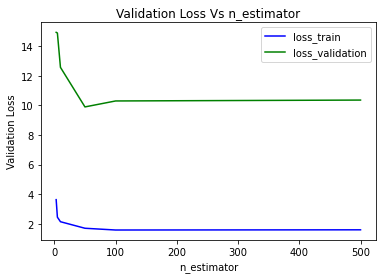

In [391]:
# Reducing the range of plot to obtain accurate estimate
range_val = 6
plot_loss_graph(rf_i_values1[0:range_val], rf_loss_train1[0:range_val], rf_loss_val1[0:range_val], "Validation Loss Vs n_estimator", "n_estimator", "Validation Loss")

Therefore, from the validation plot, the appropriate value of n_estimator is found to be 50 for random forest.

### 1.1.3.2 Choosing an appropriate max_depth for Random Forest Regressor: 

In [392]:
rf_loss_train1 = []
rf_loss_val1 = []
rf_loss_test1 = []
rf_i_values1 = []

print("Random Forest Regressor - max_depth")
i = 0
max_depth_list = [1, 2, 3, 5, 10, 20, 30, 50, 100, 500, 1000, 2000, 5000, 10000]
while i < len(max_depth_list):
    start_time = time.time()
    # Initialize random forest regressor
    clf = RandomForestRegressor(max_depth=max_depth_list[i], random_state = 1)
    tree = clf.fit(X_train1, y_train1)
    building_time = time.time() - start_time
    train_results = tree.predict(X_train1)
    loss_train = mean_squared_error(train_results, y_train1)
    val_results = tree.predict(X_val1)
    loss_val = mean_squared_error(val_results, y_val1)
    test_results = tree.predict(X_test1)
    loss_test = mean_squared_error(test_results, y_test1)
    print("n_estimator = {}: ".format(max_depth_list[i]), end = "")
    print("Train Loss = {0:.2f}, ".format(loss_train), end = "")
    print("Validation Loss = {0:.2f}, ".format(loss_val), end = "")
    print("Test Loss = {0:.2f}, ".format(loss_test), end = "")
    print("buildTime = {0:.2f}s".format(building_time), end = "\n")
    rf_loss_train1.append(loss_train)
    rf_loss_val1.append(loss_val)
    rf_loss_test1.append(loss_test)
    rf_i_values1.append(max_depth_list[i])
    i += 1

Random Forest Regressor - max_depth
n_estimator = 1: Train Loss = 61.39, Validation Loss = 61.34, Test Loss = 60.59, buildTime = 0.22s
n_estimator = 2: Train Loss = 45.31, Validation Loss = 43.58, Test Loss = 46.30, buildTime = 0.16s
n_estimator = 3: Train Loss = 31.87, Validation Loss = 31.70, Test Loss = 32.20, buildTime = 0.18s
n_estimator = 5: Train Loss = 14.47, Validation Loss = 15.86, Test Loss = 15.12, buildTime = 0.22s
n_estimator = 10: Train Loss = 2.43, Validation Loss = 10.75, Test Loss = 5.85, buildTime = 0.27s
n_estimator = 20: Train Loss = 1.59, Validation Loss = 10.49, Test Loss = 5.29, buildTime = 0.24s
n_estimator = 30: Train Loss = 1.59, Validation Loss = 10.30, Test Loss = 5.20, buildTime = 0.24s
n_estimator = 50: Train Loss = 1.59, Validation Loss = 10.30, Test Loss = 5.20, buildTime = 0.23s
n_estimator = 100: Train Loss = 1.59, Validation Loss = 10.30, Test Loss = 5.20, buildTime = 0.24s
n_estimator = 500: Train Loss = 1.59, Validation Loss = 10.30, Test Loss = 5.

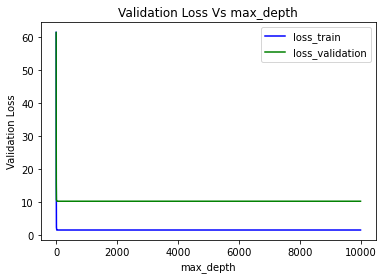

In [393]:
# Plotting validation loss vs max_depth graph
plot_loss_graph(rf_i_values1, rf_loss_train1, rf_loss_val1, "Validation Loss Vs max_depth", "max_depth", "Validation Loss")

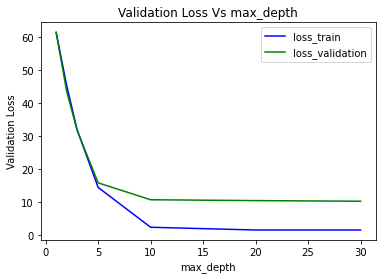

In [394]:
# Reducing the range of plot to obtain the accurate estimate
range_val = 7
plot_loss_graph(rf_i_values1[0:range_val], rf_loss_train1[0:range_val], rf_loss_val1[0:range_val], "Validation Loss Vs max_depth", "max_depth", "Validation Loss")

Therefore, from the validation plot, the appropriate value of max_depth is found to be 10 for random forest.

In [395]:
regr_rf1 = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=1)
regr_rf1.fit(X_train1, y_train1)

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=1)

### 1.1.3.4 Choosing an appropriate max_depth for Extra Trees Regressor: 

In [396]:
etr_loss_train1 = []
etr_loss_val1 = []
etr_loss_test1 = []
etr_i_values1 = []

print("Extra Random Forest Regressor - max_depth")
i = 0
max_depth_list = [1, 2, 3, 5, 10, 15, 20, 25, 30, 50, 100, 500, 1000, 2000, 5000, 10000]
while i < len(max_depth_list):
    start_time = time.time()
    # Initialize extra trees regressor
    clf = ExtraTreesRegressor(max_depth=max_depth_list[i], random_state = 1)
    tree = clf.fit(X_train1, y_train1)
    building_time = time.time() - start_time
    train_results = tree.predict(X_train1)
    loss_train = mean_squared_error(train_results, y_train1)
    val_results = tree.predict(X_val1)
    loss_val = mean_squared_error(val_results, y_val1)
    test_results = tree.predict(X_test1)
    loss_test = mean_squared_error(test_results, y_test1)
    print("n_estimator = {}: ".format(max_depth_list[i]), end = "")
    print("Train Loss = {0:.2f}, ".format(loss_train), end = "")
    print("Validation Loss = {0:.2f}, ".format(loss_val), end = "")
    print("Test Loss = {0:.2f}, ".format(loss_test), end = "")
    print("buildTime = {0:.2f}s".format(building_time), end = "\n")
    etr_loss_train1.append(loss_train)
    etr_loss_val1.append(loss_val)
    etr_loss_test1.append(loss_test)
    etr_i_values1.append(max_depth_list[i])
    i += 1

Extra Random Forest Regressor - max_depth
n_estimator = 1: Train Loss = 75.93, Validation Loss = 80.95, Test Loss = 67.25, buildTime = 0.10s
n_estimator = 2: Train Loss = 58.27, Validation Loss = 59.48, Test Loss = 51.29, buildTime = 0.07s
n_estimator = 3: Train Loss = 42.88, Validation Loss = 41.87, Test Loss = 37.66, buildTime = 0.07s
n_estimator = 5: Train Loss = 24.06, Validation Loss = 20.34, Test Loss = 20.26, buildTime = 0.08s
n_estimator = 10: Train Loss = 3.17, Validation Loss = 8.54, Test Loss = 5.62, buildTime = 0.12s
n_estimator = 15: Train Loss = 0.04, Validation Loss = 9.39, Test Loss = 3.35, buildTime = 0.15s
n_estimator = 20: Train Loss = 0.00, Validation Loss = 8.79, Test Loss = 3.49, buildTime = 0.14s
n_estimator = 25: Train Loss = 0.00, Validation Loss = 8.81, Test Loss = 3.32, buildTime = 0.14s
n_estimator = 30: Train Loss = 0.00, Validation Loss = 8.81, Test Loss = 3.32, buildTime = 0.14s
n_estimator = 50: Train Loss = 0.00, Validation Loss = 8.81, Test Loss = 3.32

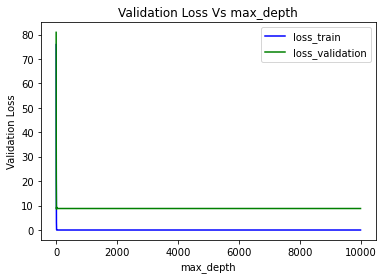

In [397]:
# Plotting validation loss vs max_depth graph
plot_loss_graph(etr_i_values1, etr_loss_train1, etr_loss_val1, "Validation Loss Vs max_depth", "max_depth", "Validation Loss")

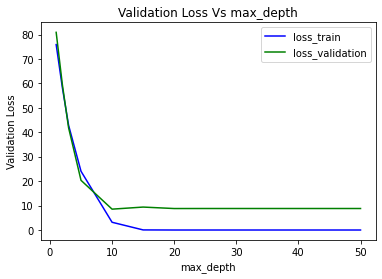

In [398]:
# Reducing the range of plot to obtain accurate estimate
range_val = 10
plot_loss_graph(etr_i_values1[0:range_val], etr_loss_train1[0:range_val], etr_loss_val1[0:range_val], "Validation Loss Vs max_depth", "max_depth", "Validation Loss")

Therefore, from the validation plot, the appropriate value of max_depth is found to be 10 for extra trees regressor.

In [399]:
regr_etr1 = ExtraTreesRegressor(max_depth=10, random_state=1)
regr_etr1.fit(X_train1, y_train1)

ExtraTreesRegressor(max_depth=10, random_state=1)

### 1.1.3.5 Choosing an appropriate max_depth for Gradient Boosting Regressor: 

In [400]:
gb_loss_train1 = []
gb_loss_val1 = []
gb_loss_test1 = []
gb_i_values1 = []

print("Gradient Boosting - n_estimators")
i = 0
n_estimators_list = [1, 2, 3, 5, 10, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000]
while i < len(n_estimators_list):
    start_time = time.time()
    # Initialize gradient boosting regressor
    clf = GradientBoostingRegressor(n_estimators=n_estimators_list[i], random_state = 1)
    tree = clf.fit(X_train1, y_train1)
    building_time = time.time() - start_time
    train_results = tree.predict(X_train1)
    loss_train = mean_squared_error(train_results, y_train1)
    val_results = tree.predict(X_val1)
    loss_val = mean_squared_error(val_results, y_val1)
    test_results = tree.predict(X_test1)
    loss_test = mean_squared_error(test_results, y_test1)
    print("n_estimator = {}: ".format(n_estimators_list[i]), end = "")
    print("Train Loss = {0:.2f}, ".format(loss_train), end = "")
    print("Validation Loss = {0:.2f}, ".format(loss_val), end = "")
    print("Test Loss = {0:.2f}, ".format(loss_test), end = "")
    print("buildTime = {0:.2f}s".format(building_time), end = "\n")
    gb_loss_train1.append(loss_train)
    gb_loss_val1.append(loss_val)
    gb_loss_test1.append(loss_test)
    gb_i_values1.append(n_estimators_list[i])
    i += 1

Gradient Boosting - n_estimators
n_estimator = 1: Train Loss = 88.33, Validation Loss = 98.37, Test Loss = 79.85, buildTime = 0.00s
n_estimator = 2: Train Loss = 78.61, Validation Loss = 87.44, Test Loss = 71.05, buildTime = 0.00s
n_estimator = 3: Train Loss = 71.52, Validation Loss = 78.62, Test Loss = 65.98, buildTime = 0.00s
n_estimator = 5: Train Loss = 58.40, Validation Loss = 64.06, Test Loss = 55.10, buildTime = 0.01s
n_estimator = 10: Train Loss = 38.03, Validation Loss = 42.39, Test Loss = 37.35, buildTime = 0.01s
n_estimator = 50: Train Loss = 10.55, Validation Loss = 15.53, Test Loss = 12.94, buildTime = 0.07s
n_estimator = 100: Train Loss = 5.24, Validation Loss = 14.07, Test Loss = 9.65, buildTime = 0.10s
n_estimator = 200: Train Loss = 2.05, Validation Loss = 13.61, Test Loss = 7.60, buildTime = 0.20s
n_estimator = 300: Train Loss = 0.95, Validation Loss = 13.54, Test Loss = 6.53, buildTime = 0.30s
n_estimator = 400: Train Loss = 0.50, Validation Loss = 13.51, Test Loss =

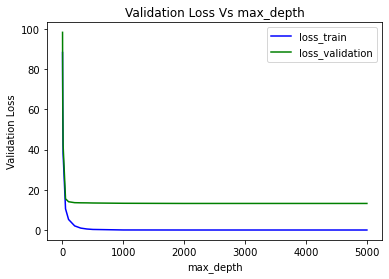

In [401]:
# Plotting validation loss vs max_depth graph
plot_loss_graph(gb_i_values1, gb_loss_train1, gb_loss_val1, "Validation Loss Vs max_depth", "max_depth", "Validation Loss")

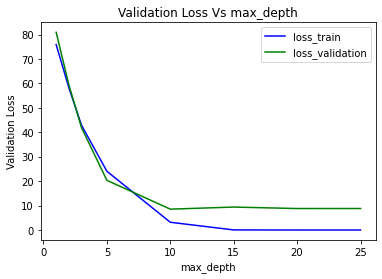

In [402]:
# Reducing the range of plot to obtain accurate estimate
range_val = 8
plot_loss_graph(etr_i_values1[0:range_val], etr_loss_train1[0:range_val], etr_loss_val1[0:range_val], "Validation Loss Vs max_depth", "max_depth", "Validation Loss")

Therefore, from the validation plot, the appropriate value of max_depth is found to be 10 for gradient boosting regressor.

In [403]:
regr_gb1 = GradientBoostingRegressor(max_depth=10, random_state=1)
regr_gb1.fit(X_train1, y_train1)

GradientBoostingRegressor(max_depth=10, random_state=1)

### KNN

In [404]:
neigh1 = KNeighborsRegressor(n_neighbors=2)
neigh1.fit(X_train1, y_train1)

KNeighborsRegressor(n_neighbors=2)

### 1.1.3.6 Building a voting regressor

In [405]:
voting_reg1 = VotingRegressor([
    ('rf', regr_rf1), 
    ('neigh', neigh1),
    ('et', regr_etr1), 
    ('gb', regr_gb1), 
], weights = [1, 2, 1, 1])
voting_reg1.fit(X_train1,y_train1)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=10,
                                                   n_estimators=50,
                                                   random_state=1)),
                            ('neigh', KNeighborsRegressor(n_neighbors=2)),
                            ('et',
                             ExtraTreesRegressor(max_depth=10, random_state=1)),
                            ('gb',
                             GradientBoostingRegressor(max_depth=10,
                                                       random_state=1))],
                weights=[1, 2, 1, 1])

### 1.1.3.7 Performance of test set on the model built using Method 1.

In [406]:
pred_test1 = voting_reg1.predict(X_test1)
print("Test Loss" + str(mean_squared_error(pred_test1, y_test1)))

Test Loss4.358582853694602


### R2 score on train, test and validation set using Method 1 model.

In [407]:
pred_train1 = voting_reg1.predict(X_train1)
pred_val1 = voting_reg1.predict(X_val1)
print(r2_score(pred_train1, y_train1))
print(r2_score(pred_val1, y_val1))
print(r2_score(y_test1, pred_test1))

0.9838309408259284
0.8973552487519563
0.9478418499264166


### Plotting prediction from different models.

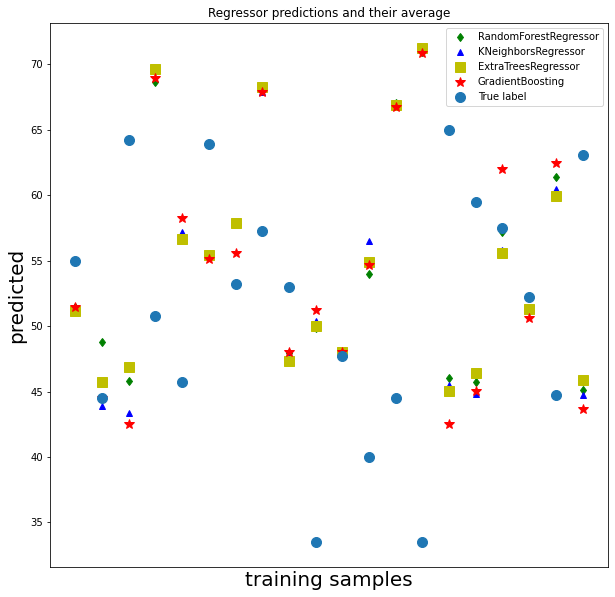

In [408]:
plt.rcParams['figure.figsize'] = [10, 10]
xt = X_test1[:20]

pred1 = regr_rf1.predict(xt)
pred2 = neigh1.predict(xt)
pred3 = regr_etr1.predict(xt)
pred4 = regr_gb1.predict(xt)

plt.figure()
plt.plot(pred1, "gd", label="RandomForestRegressor")
plt.plot(pred2, "b^", label="KNeighborsRegressor")
plt.plot(pred3, "ys", ms=10,label="ExtraTreesRegressor")
plt.plot(pred4, "r*", ms=10, label="GradientBoosting")
plt.plot(y_train1[:20], "o", ms = 10, label="True label")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted", fontsize=20)
plt.xlabel("training samples", fontsize=20)
plt.legend(loc="best", fontsize = 10)
plt.title("Regressor predictions and their average")
plt.xticks(fontsize=50)
plt.show()

## Method 2:  Conversion of 80 by 11 matrix to 1 by 11 by taking average of each column.

In [409]:
dataX2, dataY2 = get_average_of_columns_each_matrix()
# shuffle data
X2, y2 = sklearn.utils.shuffle(dataX2, dataY2)

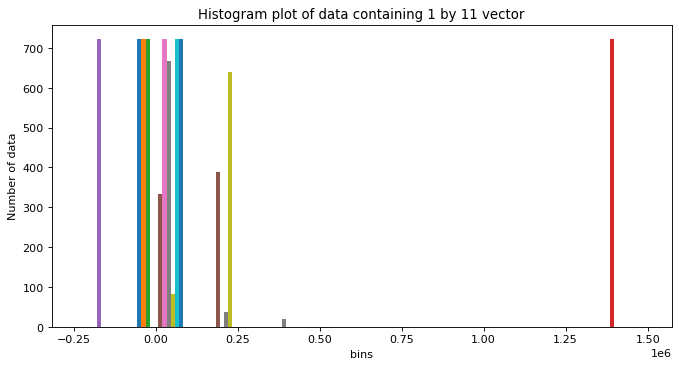

In [410]:
plot_hist(X2.squeeze(), "Histogram plot of data containing 1 by 11 vector")

As observed in method 1, we can see that our data is not normalized so, we subtracted each data by mean of the whole dataset and divided by the standard deviation so as to obtain the data with normalized values.

### 1.2.1 Normalization of data

In [411]:
# Standarization of data 
scaler = StandardScaler()
scaler.fit(X2.squeeze())
X_standardized2 = scaler.transform(X2.squeeze())

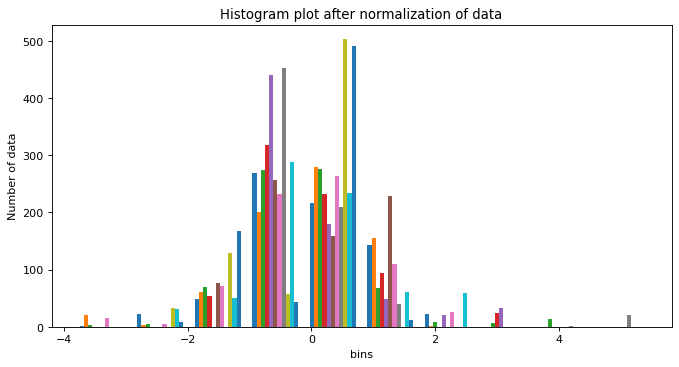

In [412]:
plot_hist(X_standardized2, "Histogram plot after normalization of data")

### 1.2.2 Dimensionality reduction

In [413]:
# Apply pca to data so to preserve 0.95 of the important features
pca = PCA(n_components=0.95)
pca.fit(X_standardized2)
pca_X2 = pca.transform(X_standardized2)

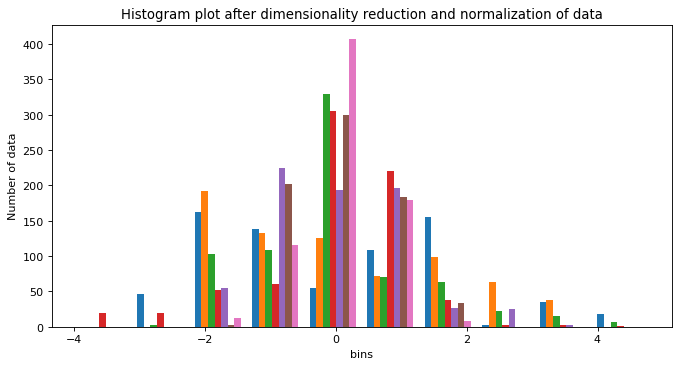

In [414]:
plot_hist(pca_X2, "Histogram plot after dimensionality reduction and normalization of data")

In [415]:
pca_X2

array([[ 0.04131871,  3.5858871 , -1.85575107, ..., -0.99465133,
         0.01233668, -1.31829403],
       [ 0.20650871, -0.8947542 , -0.44634403, ..., -0.66958602,
        -0.71360469, -0.31977365],
       [-1.19599167, -1.71515272, -0.22672588, ...,  0.29223488,
         0.59638083, -0.3383468 ],
       ...,
       [ 1.91877403, -0.2397033 , -0.15272933, ..., -0.5430757 ,
        -0.34630737,  0.12408014],
       [ 0.20910636,  3.35724718, -1.71060931, ..., -0.84690715,
         0.0109956 , -1.21902084],
       [ 0.67431885, -0.54601815,  1.60903457, ...,  0.70139545,
        -0.90106865, -0.70823759]])

As we still have large values greater than 3 in our dataset so, re-normalizing the values so as to get only the values between 0 and 1 and reduce the bias in the model.

In [416]:
scaler2 = MinMaxScaler()
scaler2.fit(pca_X2)
X_norm2 = scaler2.transform(pca_X2)

In [417]:
X_norm2

array([[0.39164351, 0.97253356, 0.07567506, ..., 0.12838768, 0.43241939,
        0.12272451],
       [0.41280982, 0.21817152, 0.27663785, ..., 0.19701774, 0.21154639,
        0.40320011],
       [0.23310309, 0.080049  , 0.3079525 , ..., 0.40008409, 0.61011911,
        0.39798308],
       ...,
       [0.63220768, 0.32845608, 0.31850343, ..., 0.22372748, 0.3232993 ,
        0.52787475],
       [0.41314266, 0.93403968, 0.09637035, ..., 0.15958046, 0.43201135,
        0.15060947],
       [0.47275178, 0.27688483, 0.56970765, ..., 0.48646894, 0.15450911,
        0.294084  ]])

Next, we split the data into train, test and validation set in the ratio 70:20:10 in method 2 as well.

In [418]:
# Split into train, validation and test set in the ratio 70:20:10
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_norm2, y2, test_size=0.1, shuffle=True, random_state=1)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.2, shuffle=True, random_state=1)

In [419]:
X_train2.shape

(519, 7)

### 1.2.3 Using Voting Regressor For Training


After getting normalized data, we trained ensemble regressor containing random forest regressor, k neighbors regressor, gradient boosting and extra trees regressor. The appropriate n_estimator and max_depth in random forest regressor, max_depth in extra trees regressor and n_estimators in gradient boosting regressor was found using loss verses the particular hyperparameter plot.

### 1.2.3.1 Choosing an appropriate n_estimators for Random Forest Regressor:

In [420]:
rf_loss_train2 = []
rf_loss_val2 = []
rf_loss_test2 = []
rf_i_values2 = []

print("Random Forest Regressor - n_estimators")
i = 0
n_estimators_list = [3, 5, 10, 50, 100, 500, 5000]
while i < len(n_estimators_list):
    start_time = time.time()
    # Initialize random forest regressor
    clf = RandomForestRegressor(n_estimators=n_estimators_list[i], random_state = 1)
    tree = clf.fit(X_train2, y_train2)
    building_time = time.time() - start_time
    train_results = tree.predict(X_train2)
    loss_train = mean_squared_error(train_results, y_train2)
    val_results = tree.predict(X_val2)
    loss_val = mean_squared_error(val_results, y_val2)
    test_results = tree.predict(X_test2)
    loss_test = mean_squared_error(test_results, y_test2)
    print("n_estimator = {}: ".format(n_estimators_list[i]), end = "")
    print("Train Loss = {0:.2f}, ".format(loss_train), end = "")
    print("Validation Loss = {0:.2f}, ".format(loss_val), end = "")
    print("Test Loss = {0:.2f}, ".format(loss_test), end = "")
    print("buildTime = {0:.2f}s".format(building_time), end = "\n")
    rf_loss_train2.append(loss_train)
    rf_loss_val2.append(loss_val)
    rf_loss_test2.append(loss_test)
    rf_i_values2.append(n_estimators_list[i])
    i += 1

Random Forest Regressor - n_estimators
n_estimator = 3: Train Loss = 3.08, Validation Loss = 20.45, Test Loss = 10.93, buildTime = 0.01s
n_estimator = 5: Train Loss = 3.05, Validation Loss = 17.03, Test Loss = 8.23, buildTime = 0.02s
n_estimator = 10: Train Loss = 2.19, Validation Loss = 18.06, Test Loss = 8.31, buildTime = 0.04s
n_estimator = 50: Train Loss = 1.41, Validation Loss = 14.09, Test Loss = 7.66, buildTime = 0.12s
n_estimator = 100: Train Loss = 1.33, Validation Loss = 14.46, Test Loss = 7.37, buildTime = 0.25s
n_estimator = 500: Train Loss = 1.31, Validation Loss = 14.76, Test Loss = 7.32, buildTime = 1.15s
n_estimator = 5000: Train Loss = 1.32, Validation Loss = 14.34, Test Loss = 7.24, buildTime = 11.51s


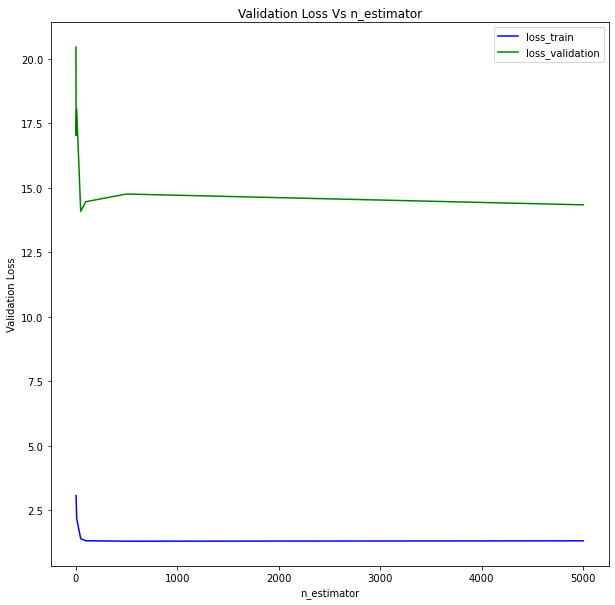

In [421]:
# Plotting validation loss vs n_estimator graph
plot_loss_graph(rf_i_values2, rf_loss_train2, rf_loss_val2, "Validation Loss Vs n_estimator", "n_estimator", "Validation Loss")

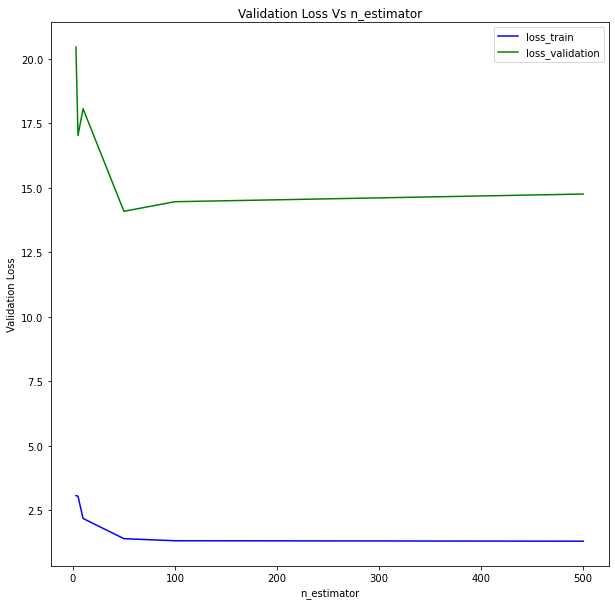

In [422]:
# Reducing the range of plot to obtain accurate estimate
range_val = 6
plot_loss_graph(rf_i_values2[0:range_val], rf_loss_train2[0:range_val], rf_loss_val2[0:range_val], "Validation Loss Vs n_estimator", "n_estimator", "Validation Loss")

### 1.2.3.2 Choosing an appropriate max_depth for Random Forest Regressor:

In [423]:
rf_loss_train2 = []
rf_loss_val2 = []
rf_loss_test2 = []
rf_i_values2 = []

print("Random Forest Regressor - max_depth")
i = 0
max_depth_list = [1, 2, 3, 5, 10, 20, 30, 50, 100, 500, 1000, 2000, 5000, 10000]
while i < len(max_depth_list):
    start_time = time.time()
    # Initialize random forest regressor
    clf = RandomForestRegressor(max_depth=max_depth_list[i], random_state = 1)
    tree = clf.fit(X_train2, y_train2)
    building_time = time.time() - start_time
    train_results = tree.predict(X_train2)
    loss_train = mean_squared_error(train_results, y_train2)
    val_results = tree.predict(X_val2)
    loss_val = mean_squared_error(val_results, y_val2)
    test_results = tree.predict(X_test2)
    loss_test = mean_squared_error(test_results, y_test2)
    print("n_estimator = {}: ".format(max_depth_list[i]), end = "")
    print("Train Loss = {0:.2f}, ".format(loss_train), end = "")
    print("Validation Loss = {0:.2f}, ".format(loss_val), end = "")
    print("Test Loss = {0:.2f}, ".format(loss_test), end = "")
    print("buildTime = {0:.2f}s".format(building_time), end = "\n")
    rf_loss_train2.append(loss_train)
    rf_loss_val2.append(loss_val)
    rf_loss_test2.append(loss_test)
    rf_i_values2.append(max_depth_list[i])
    i += 1

Random Forest Regressor - max_depth
n_estimator = 1: Train Loss = 61.84, Validation Loss = 57.76, Test Loss = 55.28, buildTime = 0.16s
n_estimator = 2: Train Loss = 44.18, Validation Loss = 43.09, Test Loss = 40.28, buildTime = 0.13s
n_estimator = 3: Train Loss = 32.90, Validation Loss = 34.81, Test Loss = 31.28, buildTime = 0.13s
n_estimator = 5: Train Loss = 14.39, Validation Loss = 23.67, Test Loss = 16.24, buildTime = 0.18s
n_estimator = 10: Train Loss = 1.94, Validation Loss = 14.83, Test Loss = 7.95, buildTime = 0.24s
n_estimator = 20: Train Loss = 1.33, Validation Loss = 14.54, Test Loss = 7.43, buildTime = 0.23s
n_estimator = 30: Train Loss = 1.33, Validation Loss = 14.46, Test Loss = 7.37, buildTime = 0.26s
n_estimator = 50: Train Loss = 1.33, Validation Loss = 14.46, Test Loss = 7.37, buildTime = 0.25s
n_estimator = 100: Train Loss = 1.33, Validation Loss = 14.46, Test Loss = 7.37, buildTime = 0.27s
n_estimator = 500: Train Loss = 1.33, Validation Loss = 14.46, Test Loss = 7.

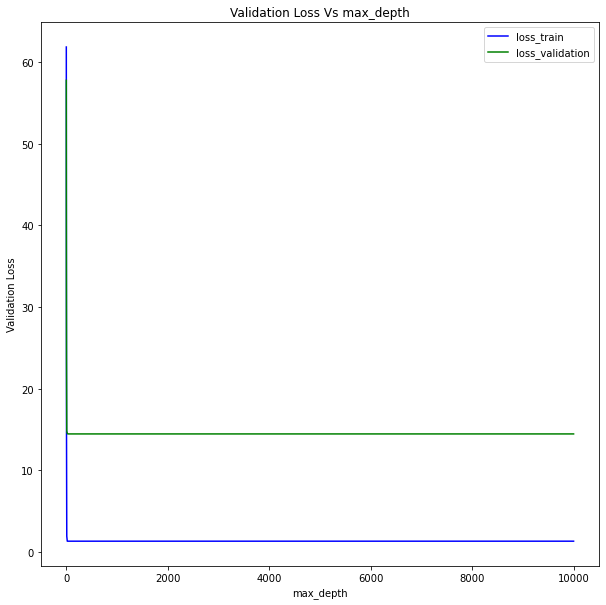

In [424]:
# Plotting validation loss vs max_depth graph
plot_loss_graph(rf_i_values2, rf_loss_train2, rf_loss_val2, "Validation Loss Vs max_depth", "max_depth", "Validation Loss")

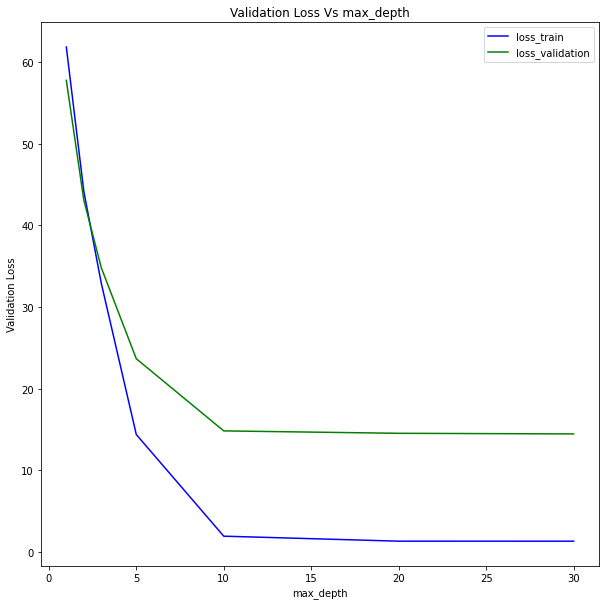

In [425]:
# Reducing the range of plot to obtain accurate estimate
range_val = 7
plot_loss_graph(rf_i_values2[0:range_val], rf_loss_train2[0:range_val], rf_loss_val2[0:range_val], "Validation Loss Vs max_depth", "max_depth", "Validation Loss")

Therefore, from the validation plot, the appropriate value of max_depth is found to be 10 for random forest.

In [426]:
regr_rf2 = RandomForestRegressor(n_estimators=50, max_depth=10, random_state = 1)
regr_rf2.fit(X_train2, y_train2)

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=1)

### 1.2.3.4 Choosing an appropriate max_depth for Extra Trees Regressor:

In [427]:
etr_loss_train2 = []
etr_loss_val2 = []
etr_loss_test2 = []
etr_i_values2 = []

print("Extra Random Forest Regressor - max_depth")
i = 0
max_depth_list = [1, 2, 3, 5, 10, 15, 20, 25, 30, 50, 100, 500, 1000, 2000, 5000, 10000]
while i < len(max_depth_list):
    start_time = time.time()
    # Initialize random forest regressor
    clf = ExtraTreesRegressor(max_depth=max_depth_list[i], random_state = 1)
    tree = clf.fit(X_train2, y_train2)
    building_time = time.time() - start_time
    train_results = tree.predict(X_train2)
    loss_train = mean_squared_error(train_results, y_train2)
    val_results = tree.predict(X_val2)
    loss_val = mean_squared_error(val_results, y_val2)
    test_results = tree.predict(X_test2)
    loss_test = mean_squared_error(test_results, y_test2)
    print("n_estimator = {}: ".format(max_depth_list[i]), end = "")
    print("Train Loss = {0:.2f}, ".format(loss_train), end = "")
    print("Validation Loss = {0:.2f}, ".format(loss_val), end = "")
    print("Test Loss = {0:.2f}, ".format(loss_test), end = "")
    print("buildTime = {0:.2f}s".format(building_time), end = "\n")
    etr_loss_train2.append(loss_train)
    etr_loss_val2.append(loss_val)
    etr_loss_test2.append(loss_test)
    etr_i_values2.append(max_depth_list[i])
    i += 1

Extra Random Forest Regressor - max_depth
n_estimator = 1: Train Loss = 77.17, Validation Loss = 69.51, Test Loss = 67.28, buildTime = 0.13s
n_estimator = 2: Train Loss = 57.60, Validation Loss = 51.56, Test Loss = 47.01, buildTime = 0.09s
n_estimator = 3: Train Loss = 40.81, Validation Loss = 37.38, Test Loss = 33.37, buildTime = 0.10s
n_estimator = 5: Train Loss = 21.79, Validation Loss = 23.55, Test Loss = 17.49, buildTime = 0.10s
n_estimator = 10: Train Loss = 3.19, Validation Loss = 13.00, Test Loss = 6.40, buildTime = 0.11s
n_estimator = 15: Train Loss = 0.08, Validation Loss = 10.44, Test Loss = 5.86, buildTime = 0.15s
n_estimator = 20: Train Loss = 0.00, Validation Loss = 10.17, Test Loss = 5.74, buildTime = 0.15s
n_estimator = 25: Train Loss = 0.00, Validation Loss = 10.40, Test Loss = 5.93, buildTime = 0.16s
n_estimator = 30: Train Loss = 0.00, Validation Loss = 10.40, Test Loss = 5.93, buildTime = 0.14s
n_estimator = 50: Train Loss = 0.00, Validation Loss = 10.40, Test Loss 

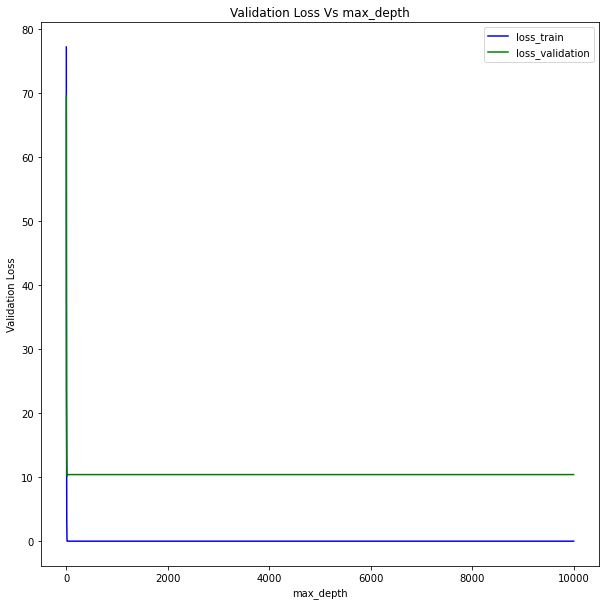

In [428]:
# Plotting validation loss vs max_depth graph
plot_loss_graph(etr_i_values2, etr_loss_train2, etr_loss_val2, "Validation Loss Vs max_depth", "max_depth", "Validation Loss")

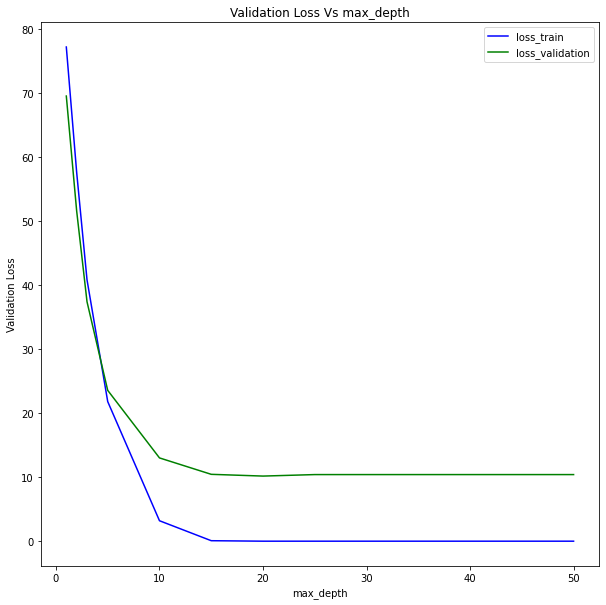

In [429]:
# Reducing the range of plot to obtain accurate estimate
range_val = 10
plot_loss_graph(etr_i_values2[0:range_val], etr_loss_train2[0:range_val], etr_loss_val2[0:range_val], "Validation Loss Vs max_depth", "max_depth", "Validation Loss")

Therefore, from the validation plot, the appropriate value of max_depth is found to be 10 for extra trees regressor.

In [430]:
regr_etr2 = ExtraTreesRegressor(max_depth=10, random_state=1)
regr_etr2.fit(X_train2, y_train2)

ExtraTreesRegressor(max_depth=10, random_state=1)

### 1.2.3.5 Choosing an appropriate max_depth for Gradient Boosting Regressor:

In [431]:
gb_loss_train2 = []
gb_loss_val2 = []
gb_loss_test2 = []
gb_i_values2 = []

print("Gradient Boosting - n_estimators")
i = 0
n_estimators_list = [1, 2, 3, 5, 10, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000, 5500, 6000, 7000, 10000]
while i < len(n_estimators_list):
    start_time = time.time()
    # Initialize random forest regressor
    clf = GradientBoostingRegressor(n_estimators=n_estimators_list[i], random_state = 1)
    tree = clf.fit(X_train2, y_train2)
    building_time = time.time() - start_time
    train_results = tree.predict(X_train2)
    loss_train = mean_squared_error(train_results, y_train2)
    val_results = tree.predict(X_val2)
    loss_val = mean_squared_error(val_results, y_val2)
    test_results = tree.predict(X_test2)
    loss_test = mean_squared_error(test_results, y_test2)
    print("n_estimator = {}: ".format(n_estimators_list[i]), end = "")
    print("Train Loss = {0:.2f}, ".format(loss_train), end = "")
    print("Validation Loss = {0:.2f}, ".format(loss_val), end = "")
    print("Test Loss = {0:.2f}, ".format(loss_test), end = "")
    print("buildTime = {0:.2f}s".format(building_time), end = "\n")
    gb_loss_train2.append(loss_train)
    gb_loss_val2.append(loss_val)
    gb_loss_test2.append(loss_test)
    gb_i_values2.append(n_estimators_list[i])
    i += 1

Gradient Boosting - n_estimators
n_estimator = 1: Train Loss = 89.35, Validation Loss = 82.25, Test Loss = 80.83, buildTime = 0.00s
n_estimator = 2: Train Loss = 80.49, Validation Loss = 74.26, Test Loss = 73.15, buildTime = 0.00s
n_estimator = 3: Train Loss = 73.02, Validation Loss = 67.27, Test Loss = 65.49, buildTime = 0.00s
n_estimator = 5: Train Loss = 60.26, Validation Loss = 56.39, Test Loss = 53.98, buildTime = 0.01s
n_estimator = 10: Train Loss = 38.85, Validation Loss = 39.74, Test Loss = 36.33, buildTime = 0.01s
n_estimator = 50: Train Loss = 9.87, Validation Loss = 21.97, Test Loss = 16.80, buildTime = 0.06s
n_estimator = 100: Train Loss = 5.09, Validation Loss = 19.01, Test Loss = 14.01, buildTime = 0.10s
n_estimator = 200: Train Loss = 2.36, Validation Loss = 17.07, Test Loss = 12.48, buildTime = 0.20s
n_estimator = 300: Train Loss = 1.13, Validation Loss = 17.25, Test Loss = 12.12, buildTime = 0.30s
n_estimator = 400: Train Loss = 0.60, Validation Loss = 16.98, Test Loss

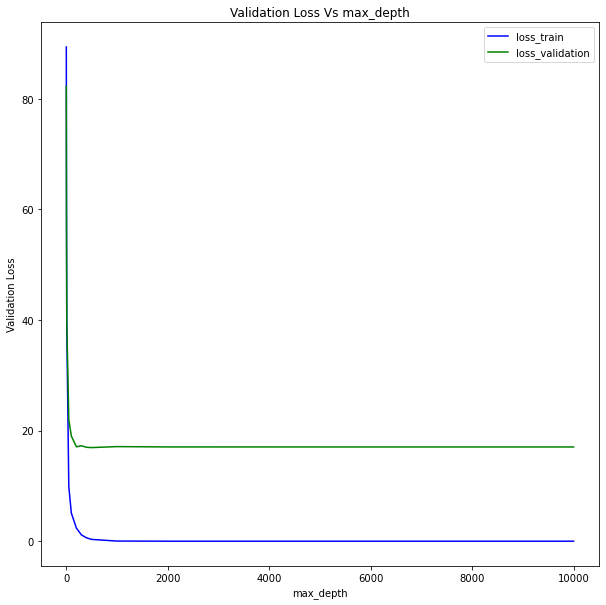

In [432]:
# Plotting validation loss vs max_depth graph
plot_loss_graph(gb_i_values2, gb_loss_train2, gb_loss_val2, "Validation Loss Vs max_depth", "max_depth", "Validation Loss")

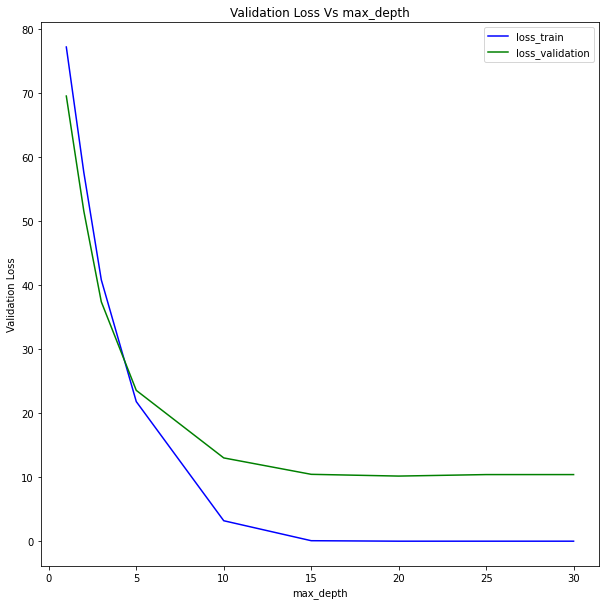

In [433]:
# Reducing the range of plot to obtain accurate estimate
range_val = 9
plot_loss_graph(etr_i_values2[0:range_val], etr_loss_train2[0:range_val], etr_loss_val2[0:range_val], "Validation Loss Vs max_depth", "max_depth", "Validation Loss")

Therefore, from the validation plot, the appropriate value of max_depth is found to be 10 for gradient boosting regressor.

In [434]:
regr_gb2 = GradientBoostingRegressor(max_depth=10, random_state=1)
regr_gb2.fit(X_train2, y_train2)

GradientBoostingRegressor(max_depth=10, random_state=1)

### KNN

In [435]:
neigh2 = KNeighborsRegressor(n_neighbors=2)
neigh2.fit(X_train2, y_train2)

KNeighborsRegressor(n_neighbors=2)

### 1.2.3.6 Building a voting regressor

In [436]:
voting_reg2 = VotingRegressor([
    ('rf', regr_rf2),
    ('neigh', neigh2),
    ('et', regr_etr2), 
    ('gb', regr_gb2)    
], weights = [1, 2, 1, 1])
voting_reg2.fit(X_train2,y_train2)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=10,
                                                   n_estimators=50,
                                                   random_state=1)),
                            ('neigh', KNeighborsRegressor(n_neighbors=2)),
                            ('et',
                             ExtraTreesRegressor(max_depth=10, random_state=1)),
                            ('gb',
                             GradientBoostingRegressor(max_depth=10,
                                                       random_state=1))],
                weights=[1, 2, 1, 1])

### 1.2.3.7 Performance of test set on the model built using Method 2.

In [437]:
pred_test2 = voting_reg2.predict(X_test2)
print("Test Loss" + str(mean_squared_error(pred_test2, y_test2)))

Test Loss5.486236354236996


### R2 scores on train, validation and test set using Method 2 model:

In [438]:
pred_train2 = voting_reg2.predict(X_train2)
pred_val2 = voting_reg2.predict(X_val2)
print(r2_score(y_train2, pred_train2))
print(r2_score(y_val2, pred_val2))
print(r2_score(y_test2, pred_test2))

0.9854956826558081
0.8706515413516211
0.9385044309131885


### Plotting predictions of various models

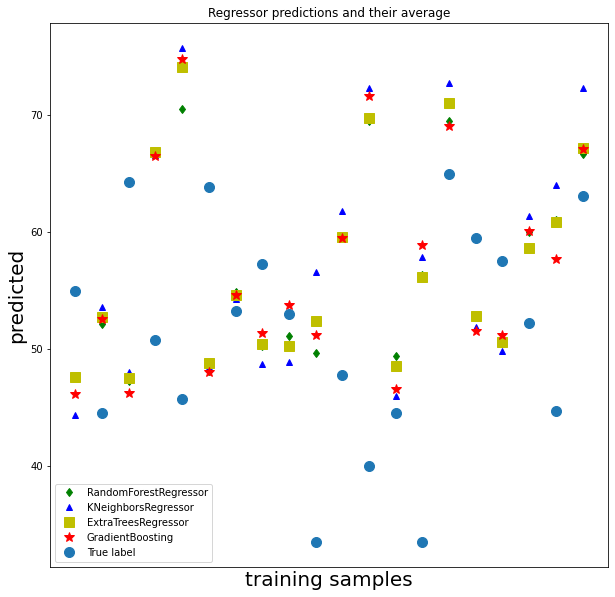

In [439]:
plt.rcParams['figure.figsize'] = [10, 10]
xt = X_test2[:20]

pred1 = regr_rf2.predict(xt)
pred2 = neigh2.predict(xt)
pred3 = regr_etr2.predict(xt)
pred4 = regr_gb2.predict(xt)

plt.figure()
plt.plot(pred1, "gd", label="RandomForestRegressor")
plt.plot(pred2, "b^", label="KNeighborsRegressor")
plt.plot(pred3, "ys", ms=10,label="ExtraTreesRegressor")
plt.plot(pred4, "r*", ms=10, label="GradientBoosting")
plt.plot(y_train1[:20], "o", ms = 10, label="True label")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted", fontsize=20)
plt.xlabel("training samples", fontsize=20)
plt.legend(loc="best", fontsize = 10)
plt.title("Regressor predictions and their average")
plt.xticks(fontsize=50)
plt.show()

Therefore, there was much difference in loss while using method 1 or method 2. Sometimes, method 2 gives the good result and sometimes, method 1 gives the good result.

## Part 2. Using neural network (RNN) to predict the propagation delay.

In case of neural network, the data was taken as a 80 by 11 matrix itself and pca was applied both in columns and rows to get important sequences and features. In this project, I decreased the size to 1 row and 5 columns using PCA. The size can be changed in src/data_loader_for_dl/SolarWindDataset.py file.

In [491]:
dataX3, dataY3 = create_dataset()
# shuffle the dataset
X3, y3 = sklearn.utils.shuffle(dataX3, dataY3)

The same steps were applied in data preprocessing in the matrix data too.
At first, the distribution of data set was converted to normal distribution using StandardScaler package of sklearn.
Then, pca was applied and the range of data was restricted to 0 and 1 (all the preprocessing steps is applied to each matrix in src/data_loader_for_dl/SolarWindDataset.py file.

For RNN, 5 layers has been used, however, 5 layers caused overfitting quite quickly in lstm so, number of layers has been reduced to 3 in case of LSTM. Even 3 number of layers caused overfitting in GRU, so, number of layers has been reduced to 2 in case of GRU.

In [492]:
# Hyperparameters
num_epochs = 2000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 5

num_classes = 1
batch_size=505

In [493]:
transform = transforms.Compose([transforms.ToTensor()]) 
dataset = SolarWindDataset(X3, y3, transform=transform)
train_set, remaining_data = torch.utils.data.random_split(dataset, [505, 217]) # 70% in training set
validation_set, test_set = torch.utils.data.random_split(remaining_data, [144, 73])  # 20% in validation and 10% in test set
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [494]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [495]:
def load_model(filepath):
    print("=> Loading saved model")
    model = RNN(input_size, hidden_size, num_layers, num_classes)
    model.load_state_dict(torch.load(filepath))
    model.eval()

### 2.1 Recurrent Neural Network (RNN)

In [496]:
model = RNN(input_size, hidden_size, num_layers, num_classes)
# initializing weights
for name, param in model.named_parameters():
  if 'bias' in name:
     nn.init.constant(param, 0.0)
  elif 'weight' in name:
     nn.init.kaiming_normal_(param)

In [497]:
# Loss and optimizer
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = 0.0
all_train_loss = []
all_val_loss = []
file_path = ""
save_model = True

for epoch in range(num_epochs):
    train_loss = 0.0
    validation_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        model.train()
        data = data.to(device=device).squeeze(2)
        targets = torch.tensor(targets).to(device=device)
        optimizer.zero_grad()
        # inverse normalize the prediction because prediction from normalized input is a normalized one
        scores = model(data.float()).squeeze(1)*np.std(dataY3)+np.mean(dataY3)
        # Set the scores to scores = model(data.float().squeeze(1))*np.std(dataY3)+np.mean(dataY3) if you are
        # using more than 1 rows of each 80 by 11 matrix.
        loss = torch.sqrt(criterion(scores.float(), targets.float()))
        # backward
        loss.backward()
        # gradient descent update step/adam step
        optimizer.step()
        train_loss += loss.item()*data.size(0)

        model.eval()
        with torch.no_grad():
          for batch_idx, (data, targets) in enumerate(validation_loader):
            data = data.to(device=device).squeeze(2)
            targets = torch.tensor(targets).to(device=device)
            logps = model.forward(data.float()).squeeze(1)*np.std(dataY3)+np.mean(dataY3)
            # Set the logps to logps = model(data.float().squeeze(1))*np.std(dataY3)+np.mean(dataY3) if you are
            # using more than 1 rows of each 80 by 11 matrix.
            batch_loss = torch.sqrt(criterion(logps.float(), targets.float()))
            validation_loss += batch_loss.item()*data.size(0)
    if (epoch % 10 == 0 and save_model):
        checkpoint_path = "saved_models/rnn/model"+str(epoch)+".path.tar"
        torch.save(model.state_dict(), checkpoint_path)
    train_loss = train_loss/len(train_loader.dataset)
    all_train_loss.append(train_loss)
    validation_loss = validation_loss/len(validation_loader.dataset)
    all_val_loss.append(validation_loss)
    print('epoch {}, Average Train Loss: {:.6f}, Average Validation Loss: {:.6f}'.format(epoch+1, train_loss, validation_loss))

epoch 1, Average Train Loss: 10.124174, Average Validation Loss: 10.428444
epoch 2, Average Train Loss: 10.119512, Average Validation Loss: 10.425673
epoch 3, Average Train Loss: 10.114900, Average Validation Loss: 10.422953
epoch 4, Average Train Loss: 10.110337, Average Validation Loss: 10.420282
epoch 5, Average Train Loss: 10.105827, Average Validation Loss: 10.417664
epoch 6, Average Train Loss: 10.101370, Average Validation Loss: 10.415097
epoch 7, Average Train Loss: 10.096966, Average Validation Loss: 10.412583
epoch 8, Average Train Loss: 10.092617, Average Validation Loss: 10.410123
epoch 9, Average Train Loss: 10.088323, Average Validation Loss: 10.407716
epoch 10, Average Train Loss: 10.084085, Average Validation Loss: 10.405362
epoch 11, Average Train Loss: 10.079905, Average Validation Loss: 10.403063
epoch 12, Average Train Loss: 10.075781, Average Validation Loss: 10.400818
epoch 13, Average Train Loss: 10.071716, Average Validation Loss: 10.398627
epoch 14, Average Tra

epoch 110, Average Train Loss: 9.916745, Average Validation Loss: 10.365443
epoch 111, Average Train Loss: 9.916575, Average Validation Loss: 10.365800
epoch 112, Average Train Loss: 9.916412, Average Validation Loss: 10.366153
epoch 113, Average Train Loss: 9.916259, Average Validation Loss: 10.366503
epoch 114, Average Train Loss: 9.916113, Average Validation Loss: 10.366848
epoch 115, Average Train Loss: 9.915975, Average Validation Loss: 10.367189
epoch 116, Average Train Loss: 9.915844, Average Validation Loss: 10.367526
epoch 117, Average Train Loss: 9.915720, Average Validation Loss: 10.367859
epoch 118, Average Train Loss: 9.915603, Average Validation Loss: 10.368187
epoch 119, Average Train Loss: 9.915491, Average Validation Loss: 10.368510
epoch 120, Average Train Loss: 9.915385, Average Validation Loss: 10.368829
epoch 121, Average Train Loss: 9.915286, Average Validation Loss: 10.369142
epoch 122, Average Train Loss: 9.915192, Average Validation Loss: 10.369451
epoch 123, A

epoch 218, Average Train Loss: 9.913689, Average Validation Loss: 10.379749
epoch 219, Average Train Loss: 9.913688, Average Validation Loss: 10.379755
epoch 220, Average Train Loss: 9.913686, Average Validation Loss: 10.379759
epoch 221, Average Train Loss: 9.913685, Average Validation Loss: 10.379763
epoch 222, Average Train Loss: 9.913684, Average Validation Loss: 10.379766
epoch 223, Average Train Loss: 9.913682, Average Validation Loss: 10.379770
epoch 224, Average Train Loss: 9.913680, Average Validation Loss: 10.379772
epoch 225, Average Train Loss: 9.913679, Average Validation Loss: 10.379775
epoch 226, Average Train Loss: 9.913678, Average Validation Loss: 10.379777
epoch 227, Average Train Loss: 9.913676, Average Validation Loss: 10.379779
epoch 228, Average Train Loss: 9.913675, Average Validation Loss: 10.379780
epoch 229, Average Train Loss: 9.913673, Average Validation Loss: 10.379781
epoch 230, Average Train Loss: 9.913671, Average Validation Loss: 10.379784
epoch 231, A

epoch 326, Average Train Loss: 9.913519, Average Validation Loss: 10.379498
epoch 327, Average Train Loss: 9.913518, Average Validation Loss: 10.379496
epoch 328, Average Train Loss: 9.913515, Average Validation Loss: 10.379492
epoch 329, Average Train Loss: 9.913514, Average Validation Loss: 10.379488
epoch 330, Average Train Loss: 9.913512, Average Validation Loss: 10.379484
epoch 331, Average Train Loss: 9.913510, Average Validation Loss: 10.379480
epoch 332, Average Train Loss: 9.913509, Average Validation Loss: 10.379478
epoch 333, Average Train Loss: 9.913507, Average Validation Loss: 10.379474
epoch 334, Average Train Loss: 9.913505, Average Validation Loss: 10.379469
epoch 335, Average Train Loss: 9.913503, Average Validation Loss: 10.379467
epoch 336, Average Train Loss: 9.913502, Average Validation Loss: 10.379463
epoch 337, Average Train Loss: 9.913499, Average Validation Loss: 10.379459
epoch 338, Average Train Loss: 9.913498, Average Validation Loss: 10.379456
epoch 339, A

epoch 434, Average Train Loss: 9.913309, Average Validation Loss: 10.379071
epoch 435, Average Train Loss: 9.913308, Average Validation Loss: 10.379067
epoch 436, Average Train Loss: 9.913305, Average Validation Loss: 10.379064
epoch 437, Average Train Loss: 9.913303, Average Validation Loss: 10.379059
epoch 438, Average Train Loss: 9.913301, Average Validation Loss: 10.379054
epoch 439, Average Train Loss: 9.913299, Average Validation Loss: 10.379050
epoch 440, Average Train Loss: 9.913297, Average Validation Loss: 10.379045
epoch 441, Average Train Loss: 9.913295, Average Validation Loss: 10.379042
epoch 442, Average Train Loss: 9.913293, Average Validation Loss: 10.379036
epoch 443, Average Train Loss: 9.913291, Average Validation Loss: 10.379033
epoch 444, Average Train Loss: 9.913289, Average Validation Loss: 10.379028
epoch 445, Average Train Loss: 9.913287, Average Validation Loss: 10.379024
epoch 446, Average Train Loss: 9.913284, Average Validation Loss: 10.379020
epoch 447, A

epoch 542, Average Train Loss: 9.913062, Average Validation Loss: 10.378564
epoch 543, Average Train Loss: 9.913059, Average Validation Loss: 10.378558
epoch 544, Average Train Loss: 9.913057, Average Validation Loss: 10.378553
epoch 545, Average Train Loss: 9.913054, Average Validation Loss: 10.378549
epoch 546, Average Train Loss: 9.913052, Average Validation Loss: 10.378542
epoch 547, Average Train Loss: 9.913049, Average Validation Loss: 10.378537
epoch 548, Average Train Loss: 9.913047, Average Validation Loss: 10.378532
epoch 549, Average Train Loss: 9.913044, Average Validation Loss: 10.378528
epoch 550, Average Train Loss: 9.913042, Average Validation Loss: 10.378523
epoch 551, Average Train Loss: 9.913039, Average Validation Loss: 10.378516
epoch 552, Average Train Loss: 9.913036, Average Validation Loss: 10.378513
epoch 553, Average Train Loss: 9.913033, Average Validation Loss: 10.378507
epoch 554, Average Train Loss: 9.913032, Average Validation Loss: 10.378502
epoch 555, A

epoch 650, Average Train Loss: 9.912772, Average Validation Loss: 10.377972
epoch 651, Average Train Loss: 9.912769, Average Validation Loss: 10.377966
epoch 652, Average Train Loss: 9.912767, Average Validation Loss: 10.377960
epoch 653, Average Train Loss: 9.912764, Average Validation Loss: 10.377954
epoch 654, Average Train Loss: 9.912761, Average Validation Loss: 10.377949
epoch 655, Average Train Loss: 9.912758, Average Validation Loss: 10.377942
epoch 656, Average Train Loss: 9.912755, Average Validation Loss: 10.377936
epoch 657, Average Train Loss: 9.912752, Average Validation Loss: 10.377930
epoch 658, Average Train Loss: 9.912749, Average Validation Loss: 10.377925
epoch 659, Average Train Loss: 9.912746, Average Validation Loss: 10.377917
epoch 660, Average Train Loss: 9.912744, Average Validation Loss: 10.377913
epoch 661, Average Train Loss: 9.912741, Average Validation Loss: 10.377906
epoch 662, Average Train Loss: 9.912738, Average Validation Loss: 10.377900
epoch 663, A

epoch 758, Average Train Loss: 9.912440, Average Validation Loss: 10.377289
epoch 759, Average Train Loss: 9.912436, Average Validation Loss: 10.377282
epoch 760, Average Train Loss: 9.912433, Average Validation Loss: 10.377275
epoch 761, Average Train Loss: 9.912430, Average Validation Loss: 10.377269
epoch 762, Average Train Loss: 9.912427, Average Validation Loss: 10.377261
epoch 763, Average Train Loss: 9.912423, Average Validation Loss: 10.377255
epoch 764, Average Train Loss: 9.912419, Average Validation Loss: 10.377248
epoch 765, Average Train Loss: 9.912417, Average Validation Loss: 10.377242
epoch 766, Average Train Loss: 9.912414, Average Validation Loss: 10.377234
epoch 767, Average Train Loss: 9.912411, Average Validation Loss: 10.377228
epoch 768, Average Train Loss: 9.912407, Average Validation Loss: 10.377220
epoch 769, Average Train Loss: 9.912404, Average Validation Loss: 10.377214
epoch 770, Average Train Loss: 9.912399, Average Validation Loss: 10.377207
epoch 771, A

epoch 866, Average Train Loss: 9.912060, Average Validation Loss: 10.376507
epoch 867, Average Train Loss: 9.912057, Average Validation Loss: 10.376498
epoch 868, Average Train Loss: 9.912052, Average Validation Loss: 10.376491
epoch 869, Average Train Loss: 9.912047, Average Validation Loss: 10.376484
epoch 870, Average Train Loss: 9.912045, Average Validation Loss: 10.376475
epoch 871, Average Train Loss: 9.912041, Average Validation Loss: 10.376468
epoch 872, Average Train Loss: 9.912037, Average Validation Loss: 10.376460
epoch 873, Average Train Loss: 9.912032, Average Validation Loss: 10.376451
epoch 874, Average Train Loss: 9.912029, Average Validation Loss: 10.376444
epoch 875, Average Train Loss: 9.912025, Average Validation Loss: 10.376436
epoch 876, Average Train Loss: 9.912022, Average Validation Loss: 10.376428
epoch 877, Average Train Loss: 9.912018, Average Validation Loss: 10.376420
epoch 878, Average Train Loss: 9.912013, Average Validation Loss: 10.376413
epoch 879, A

epoch 974, Average Train Loss: 9.911626, Average Validation Loss: 10.375610
epoch 975, Average Train Loss: 9.911621, Average Validation Loss: 10.375603
epoch 976, Average Train Loss: 9.911616, Average Validation Loss: 10.375594
epoch 977, Average Train Loss: 9.911612, Average Validation Loss: 10.375584
epoch 978, Average Train Loss: 9.911608, Average Validation Loss: 10.375576
epoch 979, Average Train Loss: 9.911604, Average Validation Loss: 10.375566
epoch 980, Average Train Loss: 9.911599, Average Validation Loss: 10.375558
epoch 981, Average Train Loss: 9.911595, Average Validation Loss: 10.375549
epoch 982, Average Train Loss: 9.911590, Average Validation Loss: 10.375540
epoch 983, Average Train Loss: 9.911587, Average Validation Loss: 10.375531
epoch 984, Average Train Loss: 9.911582, Average Validation Loss: 10.375522
epoch 985, Average Train Loss: 9.911578, Average Validation Loss: 10.375513
epoch 986, Average Train Loss: 9.911574, Average Validation Loss: 10.375504
epoch 987, A

epoch 1081, Average Train Loss: 9.911136, Average Validation Loss: 10.374599
epoch 1082, Average Train Loss: 9.911130, Average Validation Loss: 10.374588
epoch 1083, Average Train Loss: 9.911126, Average Validation Loss: 10.374578
epoch 1084, Average Train Loss: 9.911120, Average Validation Loss: 10.374568
epoch 1085, Average Train Loss: 9.911116, Average Validation Loss: 10.374557
epoch 1086, Average Train Loss: 9.911111, Average Validation Loss: 10.374548
epoch 1087, Average Train Loss: 9.911105, Average Validation Loss: 10.374537
epoch 1088, Average Train Loss: 9.911100, Average Validation Loss: 10.374528
epoch 1089, Average Train Loss: 9.911097, Average Validation Loss: 10.374516
epoch 1090, Average Train Loss: 9.911091, Average Validation Loss: 10.374507
epoch 1091, Average Train Loss: 9.911086, Average Validation Loss: 10.374496
epoch 1092, Average Train Loss: 9.911080, Average Validation Loss: 10.374486
epoch 1093, Average Train Loss: 9.911077, Average Validation Loss: 10.374475

epoch 1188, Average Train Loss: 9.910576, Average Validation Loss: 10.373441
epoch 1189, Average Train Loss: 9.910571, Average Validation Loss: 10.373428
epoch 1190, Average Train Loss: 9.910565, Average Validation Loss: 10.373417
epoch 1191, Average Train Loss: 9.910560, Average Validation Loss: 10.373405
epoch 1192, Average Train Loss: 9.910554, Average Validation Loss: 10.373394
epoch 1193, Average Train Loss: 9.910548, Average Validation Loss: 10.373382
epoch 1194, Average Train Loss: 9.910542, Average Validation Loss: 10.373371
epoch 1195, Average Train Loss: 9.910538, Average Validation Loss: 10.373359
epoch 1196, Average Train Loss: 9.910532, Average Validation Loss: 10.373347
epoch 1197, Average Train Loss: 9.910526, Average Validation Loss: 10.373336
epoch 1198, Average Train Loss: 9.910521, Average Validation Loss: 10.373323
epoch 1199, Average Train Loss: 9.910515, Average Validation Loss: 10.373312
epoch 1200, Average Train Loss: 9.910509, Average Validation Loss: 10.373301

epoch 1295, Average Train Loss: 9.909939, Average Validation Loss: 10.372113
epoch 1296, Average Train Loss: 9.909933, Average Validation Loss: 10.372100
epoch 1297, Average Train Loss: 9.909925, Average Validation Loss: 10.372087
epoch 1298, Average Train Loss: 9.909919, Average Validation Loss: 10.372074
epoch 1299, Average Train Loss: 9.909914, Average Validation Loss: 10.372060
epoch 1300, Average Train Loss: 9.909906, Average Validation Loss: 10.372047
epoch 1301, Average Train Loss: 9.909901, Average Validation Loss: 10.372033
epoch 1302, Average Train Loss: 9.909894, Average Validation Loss: 10.372021
epoch 1303, Average Train Loss: 9.909887, Average Validation Loss: 10.372006
epoch 1304, Average Train Loss: 9.909882, Average Validation Loss: 10.371993
epoch 1305, Average Train Loss: 9.909875, Average Validation Loss: 10.371980
epoch 1306, Average Train Loss: 9.909868, Average Validation Loss: 10.371966
epoch 1307, Average Train Loss: 9.909863, Average Validation Loss: 10.371953

epoch 1402, Average Train Loss: 9.909209, Average Validation Loss: 10.370590
epoch 1403, Average Train Loss: 9.909202, Average Validation Loss: 10.370575
epoch 1404, Average Train Loss: 9.909194, Average Validation Loss: 10.370560
epoch 1405, Average Train Loss: 9.909186, Average Validation Loss: 10.370544
epoch 1406, Average Train Loss: 9.909180, Average Validation Loss: 10.370529
epoch 1407, Average Train Loss: 9.909173, Average Validation Loss: 10.370513
epoch 1408, Average Train Loss: 9.909164, Average Validation Loss: 10.370499
epoch 1409, Average Train Loss: 9.909158, Average Validation Loss: 10.370482
epoch 1410, Average Train Loss: 9.909150, Average Validation Loss: 10.370468
epoch 1411, Average Train Loss: 9.909143, Average Validation Loss: 10.370452
epoch 1412, Average Train Loss: 9.909135, Average Validation Loss: 10.370437
epoch 1413, Average Train Loss: 9.909128, Average Validation Loss: 10.370421
epoch 1414, Average Train Loss: 9.909120, Average Validation Loss: 10.370406

epoch 1509, Average Train Loss: 9.908371, Average Validation Loss: 10.368836
epoch 1510, Average Train Loss: 9.908363, Average Validation Loss: 10.368818
epoch 1511, Average Train Loss: 9.908354, Average Validation Loss: 10.368801
epoch 1512, Average Train Loss: 9.908346, Average Validation Loss: 10.368784
epoch 1513, Average Train Loss: 9.908338, Average Validation Loss: 10.368766
epoch 1514, Average Train Loss: 9.908330, Average Validation Loss: 10.368748
epoch 1515, Average Train Loss: 9.908321, Average Validation Loss: 10.368731
epoch 1516, Average Train Loss: 9.908312, Average Validation Loss: 10.368712
epoch 1517, Average Train Loss: 9.908305, Average Validation Loss: 10.368695
epoch 1518, Average Train Loss: 9.908296, Average Validation Loss: 10.368678
epoch 1519, Average Train Loss: 9.908288, Average Validation Loss: 10.368659
epoch 1520, Average Train Loss: 9.908278, Average Validation Loss: 10.368641
epoch 1521, Average Train Loss: 9.908270, Average Validation Loss: 10.368623

epoch 1616, Average Train Loss: 9.907409, Average Validation Loss: 10.366812
epoch 1617, Average Train Loss: 9.907400, Average Validation Loss: 10.366792
epoch 1618, Average Train Loss: 9.907391, Average Validation Loss: 10.366771
epoch 1619, Average Train Loss: 9.907380, Average Validation Loss: 10.366751
epoch 1620, Average Train Loss: 9.907371, Average Validation Loss: 10.366730
epoch 1621, Average Train Loss: 9.907360, Average Validation Loss: 10.366710
epoch 1622, Average Train Loss: 9.907351, Average Validation Loss: 10.366689
epoch 1623, Average Train Loss: 9.907341, Average Validation Loss: 10.366669
epoch 1624, Average Train Loss: 9.907331, Average Validation Loss: 10.366648
epoch 1625, Average Train Loss: 9.907322, Average Validation Loss: 10.366629
epoch 1626, Average Train Loss: 9.907312, Average Validation Loss: 10.366608
epoch 1627, Average Train Loss: 9.907302, Average Validation Loss: 10.366587
epoch 1628, Average Train Loss: 9.907292, Average Validation Loss: 10.366566

epoch 1723, Average Train Loss: 9.906301, Average Validation Loss: 10.364471
epoch 1724, Average Train Loss: 9.906290, Average Validation Loss: 10.364448
epoch 1725, Average Train Loss: 9.906280, Average Validation Loss: 10.364424
epoch 1726, Average Train Loss: 9.906267, Average Validation Loss: 10.364401
epoch 1727, Average Train Loss: 9.906257, Average Validation Loss: 10.364377
epoch 1728, Average Train Loss: 9.906244, Average Validation Loss: 10.364353
epoch 1729, Average Train Loss: 9.906234, Average Validation Loss: 10.364330
epoch 1730, Average Train Loss: 9.906222, Average Validation Loss: 10.364306
epoch 1731, Average Train Loss: 9.906211, Average Validation Loss: 10.364283
epoch 1732, Average Train Loss: 9.906200, Average Validation Loss: 10.364259
epoch 1733, Average Train Loss: 9.906189, Average Validation Loss: 10.364235
epoch 1734, Average Train Loss: 9.906178, Average Validation Loss: 10.364211
epoch 1735, Average Train Loss: 9.906166, Average Validation Loss: 10.364187

epoch 1830, Average Train Loss: 9.905025, Average Validation Loss: 10.361762
epoch 1831, Average Train Loss: 9.905010, Average Validation Loss: 10.361734
epoch 1832, Average Train Loss: 9.904999, Average Validation Loss: 10.361708
epoch 1833, Average Train Loss: 9.904985, Average Validation Loss: 10.361680
epoch 1834, Average Train Loss: 9.904973, Average Validation Loss: 10.361653
epoch 1835, Average Train Loss: 9.904961, Average Validation Loss: 10.361626
epoch 1836, Average Train Loss: 9.904947, Average Validation Loss: 10.361598
epoch 1837, Average Train Loss: 9.904934, Average Validation Loss: 10.361571
epoch 1838, Average Train Loss: 9.904921, Average Validation Loss: 10.361543
epoch 1839, Average Train Loss: 9.904908, Average Validation Loss: 10.361515
epoch 1840, Average Train Loss: 9.904896, Average Validation Loss: 10.361488
epoch 1841, Average Train Loss: 9.904881, Average Validation Loss: 10.361461
epoch 1842, Average Train Loss: 9.904870, Average Validation Loss: 10.361432

epoch 1937, Average Train Loss: 9.903554, Average Validation Loss: 10.358625
epoch 1938, Average Train Loss: 9.903538, Average Validation Loss: 10.358594
epoch 1939, Average Train Loss: 9.903523, Average Validation Loss: 10.358563
epoch 1940, Average Train Loss: 9.903508, Average Validation Loss: 10.358531
epoch 1941, Average Train Loss: 9.903494, Average Validation Loss: 10.358500
epoch 1942, Average Train Loss: 9.903479, Average Validation Loss: 10.358468
epoch 1943, Average Train Loss: 9.903464, Average Validation Loss: 10.358436
epoch 1944, Average Train Loss: 9.903449, Average Validation Loss: 10.358404
epoch 1945, Average Train Loss: 9.903435, Average Validation Loss: 10.358372
epoch 1946, Average Train Loss: 9.903419, Average Validation Loss: 10.358340
epoch 1947, Average Train Loss: 9.903404, Average Validation Loss: 10.358310
epoch 1948, Average Train Loss: 9.903389, Average Validation Loss: 10.358277
epoch 1949, Average Train Loss: 9.903375, Average Validation Loss: 10.358245

In [498]:
epoch_numbers = np.arange(0, 2000, 1)

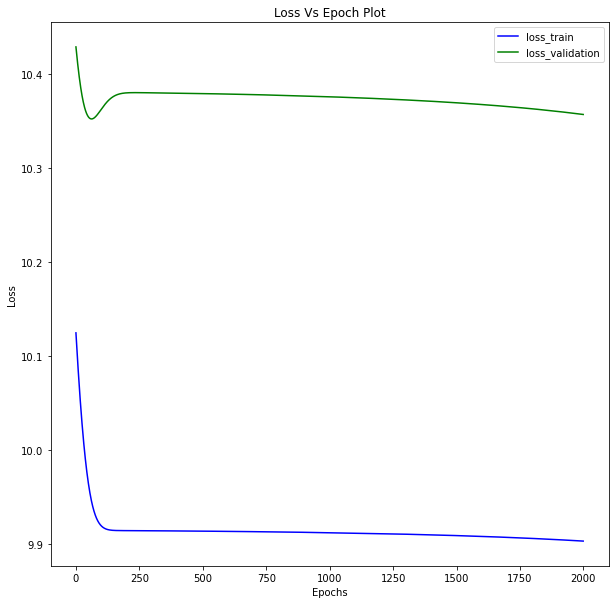

In [499]:
plot_loss_graph(epoch_numbers, all_train_loss, all_val_loss, "Loss Vs Epoch Plot", "Epochs", "Loss")

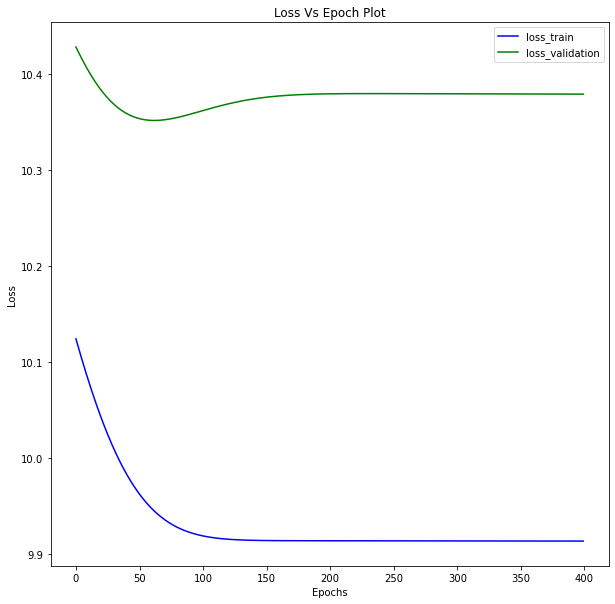

In [502]:
# reducing range to get proper hyperparameter value
range_val = 400
plot_loss_graph(epoch_numbers[0:range_val], all_train_loss[0:range_val], all_val_loss[0:range_val], "Loss Vs Epoch Plot", "Epochs", "Loss")

### Prediction on selected RNN model

In [503]:
#selected model
epoch = 150
test_loss = 0
filepath = "saved_models/rnn/model"+str(epoch)+".path.tar"
load_model(filepath)
for batch_idx, (data, targets) in enumerate(test_loader):
        data = data.to(device=device).squeeze(2)
        targets = torch.tensor(targets).to(device=device)
        scores = model(data.float()).squeeze(1)*np.std(dataY3)+np.mean(dataY3)
        loss = torch.sqrt(criterion(scores.float(), targets.float()))
        test_loss += loss.item()*data.size(0)
test_loss = test_loss/len(test_loader.dataset)
print('Average Test Loss: {:.6f}\n'.format(test_loss))

=> Loading saved model
Average Test Loss: 9.264805



## Final model selection

Among the three methods we tried, method 1 and method 2 gave the lowest loss. Among these two methods, I am selecting method 1 as the final model as this gave the lowest loss in this run.

In [504]:
final_model = voting_reg1
prediction_test_final = final_model.predict(X_test1)
print("Loss" + str(mean_squared_error(prediction_test_final, y_test1)))
print("R2 score" + str(r2_score(y_test1, prediction_test_final)))

Loss4.358582853694602
R2 score0.9478418499264166


## Validation of final selected model on test set

Now, we validate our model on random sample of test set.

In [505]:
import random
x = random.randint(0,70)

In [506]:
y_pred = final_model.predict(X_test1[[x]])
y_true = y_test1[3]
print("Prediction by model is: ", y_pred)
print("True label is: ", y_true)

Prediction by model is:  [71.1085315]
True label is:  71.75


Therefore, we tried ensemble regressors on two types of data sets. We also tried RNN on our dataset. As there is less data, ensemble regressors gave better result than RNN. Then, we selected ensemble regressor trained using dataset from method 1 as our final model and infer and validated a random test data from the model. 